In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
from utils import *
from PIL import Image
from pathlib import Path

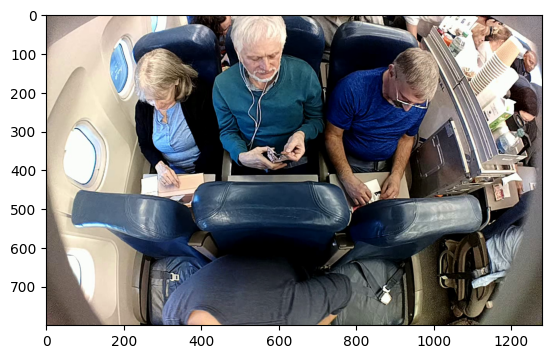

In [42]:
for a in [3]:
    video_path = f'/mnt/FAA/CATR/Pilot/Cabin-aligned/rowL-{a}.mp4'
    video = cv2.VideoCapture(video_path)
    video_name = Path(video_path).stem
    annotations = json.load(open(f"/mnt/FAA/CATR/Pilot/Calibration/oak/images/{video_name}.json",'r'))
    img_shape = (annotations['imageHeight'],annotations['imageWidth'])
    bbox_seat = {}
    mask_seat = {}
    mask_seat_back =  []
    bbox_seat_back = []
    for ann in annotations["shapes"]:
        mask = shape_to_mask(img_shape, ann['points'])
        bbox = mask_to_box(mask)
        if ann['label'] == 'seat':
            bbox_seat_back.append(bbox)
            mask_seat_back.append(mask)
    curr = 59*60*15+700
    video.set(cv2.CAP_PROP_POS_FRAMES, curr)
    ret, frame = video.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    new_frame = frame*np.expand_dims(mask_seat_back[2],2)
    seat_colour = np.ma.masked_equal(new_frame, 0).mean(axis=(0,1)).data
    for i in range(0,100):
        ret, frame = video.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        new_frame = frame*np.expand_dims(mask_seat_back[0],2)
    #new_frame[:] = seat_colour
    plt.imshow(frame)
    plt.show()
    video.release()



In [14]:
new_frame.shape

(800, 1280, 3)

In [18]:
np.ma.masked_equal(new_frame, 0).mean(axis=(0,1)).data


array([53.01112608, 68.15644482, 80.69804637])